# Occupazione della stanza

Per prima cosa iniziamo a recuperare il dataset

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

X = pd.read_csv('./data/datatraining.txt')

Quindi andiamo a creare una nuova feature che indica il giorno della settimana (facciamo un mapping con i nomi dei giorni in italiano)

In [2]:
X['date'] = pd.to_datetime(X['date'], format='mixed')
X['weekday'] = X['date'].dt.day_name()
mapping = {
    'Monday': 'Lunedì', 'Tuesday': 'Martedì', 'Wednesday': 'Mercoledì',
    'Thursday': 'Giovedì', 'Friday': 'Venerdì', 'Saturday': 'Sabato', 'Sunday': 'Domenica'
}
order = ['Lunedì', 'Martedì', 'Mercoledì', 'Giovedì', 'Venerdì', 'Sabato', 'Domenica']
X['weekday'] = X['weekday'].map(mapping)

Visualizziamo il numero di presenze per ogni giorno della settimana

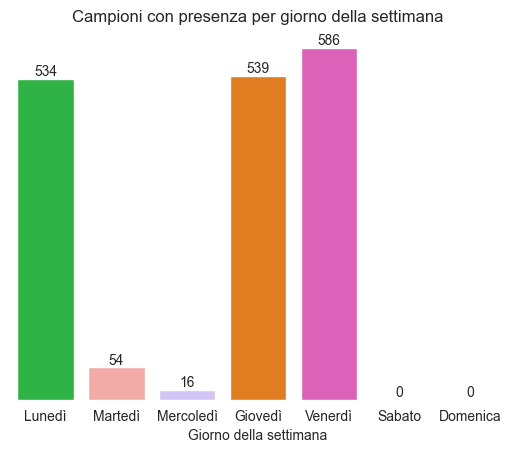

In [3]:
counts = X.groupby('weekday')['Occupancy'].sum()

palette = sns.color_palette("pastel", n_colors=len(counts))
for i, count in enumerate(counts.values):
    if count > 500:
        palette[i] = sns.color_palette("bright")[i]
sns.set_style('white')

barplot = sns.barplot(x=counts.index, y=counts.values, order=order, hue=counts.index, palette=palette)
plt.xlabel('Giorno della settimana')
plt.title('Campioni con presenza per giorno della settimana')

barplot.set(yticklabels=[])

for container in barplot.containers:
    barplot.bar_label(container, fmt='%d', label_type='edge')

for spine in barplot.spines.values():
    spine.set_visible(False)

plt.savefig("./plots/campioni_con_presenza_per_giorno.png", transparent=True)

plt.show()

Notiamo dal barchart che si ha una particolare presenza il lunedì, il giovedì e il venerdì, mentre il sabato e la domenica non c'è mai nessuno nella stanza.

Ora proviamo a visualizzare, utilizzando degli small multiples, l'andamento temporale di ogni feature, rispetto al fatto che ci sia o meno qualcuno nella stanza (evidenziando in rosso quando qualcuno è presente nella stanza) e dividendo i giorni con delle barre verticali.

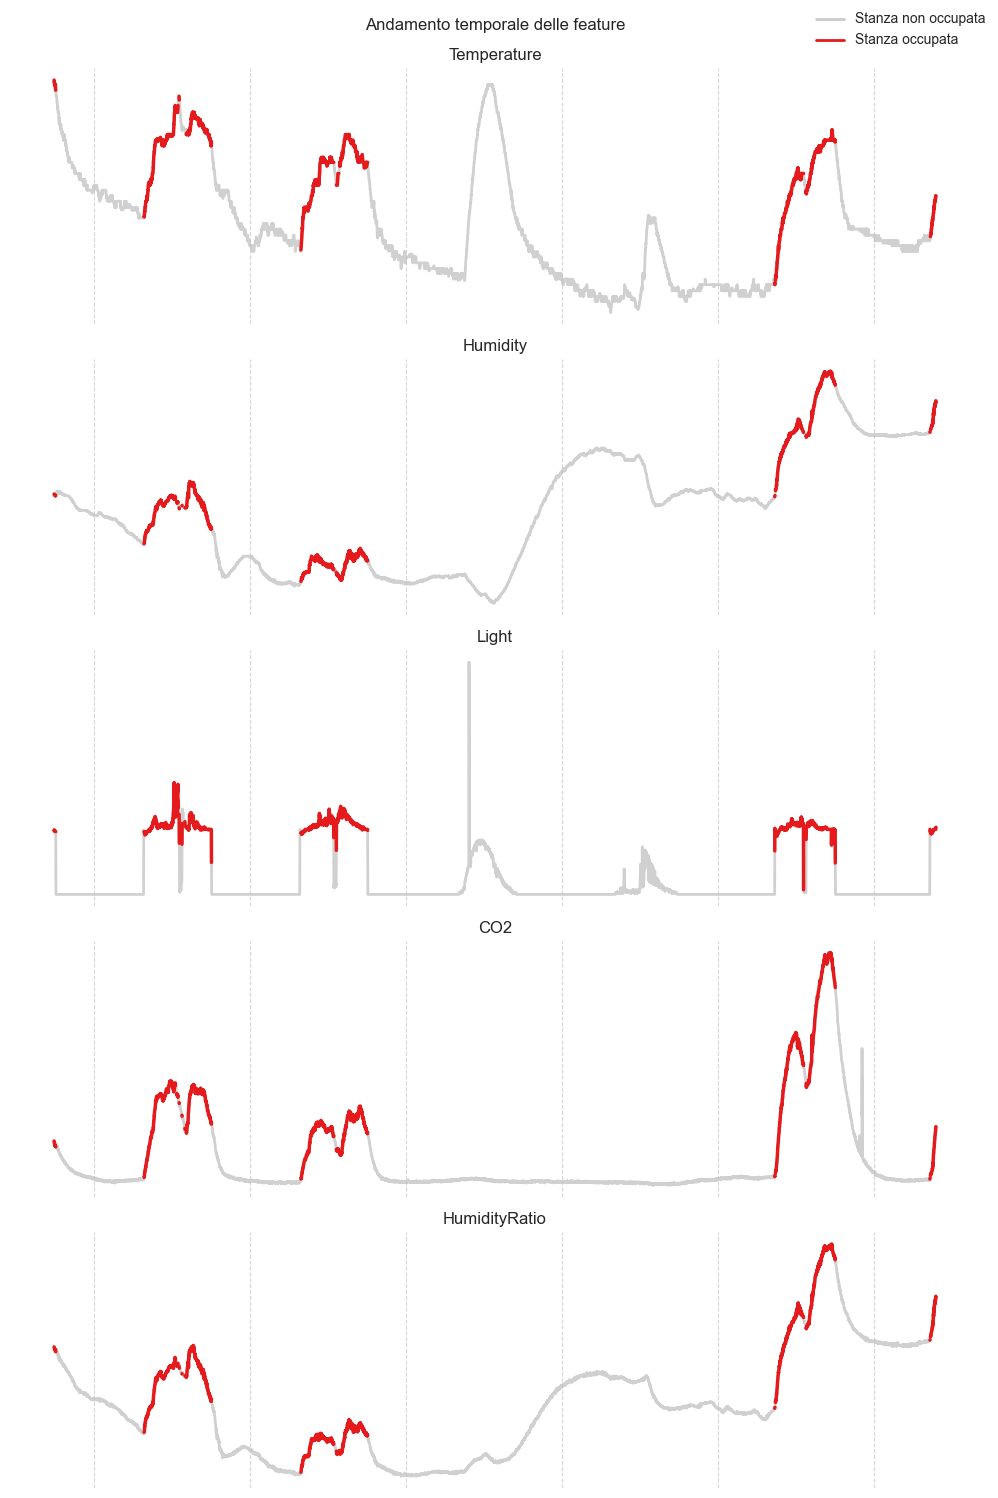

In [4]:
# stile minimale
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# configurazione colori
grey = '#bdbdbd'
red = '#e41a1c'

# seleziona feature numeriche (escludi date, weekday, Occupancy)
features = [c for c in X.columns if c not in ['date', 'weekday', 'Occupancy']]

# layout dei subplot
n = len(features)
columns = 1
rows = math.ceil(n / columns)
fig, axes = plt.subplots(rows, columns, figsize=(10 * columns, 3 * rows), squeeze=False)
axes = axes.ravel()

for ax, feat in zip(axes, features):
    sub = X[['date', 'Occupancy', feat]].sort_values('date').dropna(subset=['date', feat])

    # disegna la serie completa in grigio
    ax.plot(sub['date'], sub[feat], color=grey, alpha=0.7, linewidth=2)

    # trova blocchi continui dove Occupancy == 1 e disegna solo quei segmenti in rosso
    mask = sub['Occupancy'] == 1
    # ogni volta che mask cambia, si crea un nuovo gruppo
    groups = mask.ne(mask.shift(fill_value=False)).cumsum()
    for _, grp in sub.groupby(groups):
        if grp['Occupancy'].iloc[0] == 1:
            ax.plot(grp['date'], grp[feat], color=red, alpha=1.0, linewidth=2.5)

    # linee verticali a mezzanotte
    days = pd.to_datetime(sub['date'].dt.normalize().unique())
    y_min, y_max = ax.get_ylim()
    for day in days:
        t = day
        if sub['date'].iloc[0] <= t <= sub['date'].iloc[-1]:
            ax.axvline(t, color=grey, linestyle='--', linewidth=0.8, alpha=0.6)

    ax.set_title(feat)
    # rimuovi bordi e tacche per uno stile minimale
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

# legenda senza bordo
handle0 = mlines.Line2D([], [], color=grey, label='Stanza non occupata', linewidth=2, alpha=0.8)
handle1 = mlines.Line2D([], [], color=red, label='Stanza occupata', linewidth=2)
fig.legend(handles=[handle0, handle1], loc='upper right', frameon=False)
fig.suptitle('Andamento temporale delle feature', y=0.99)
plt.tight_layout()
plt.savefig("./plots/andamento_temporale_features.png")
plt.show()

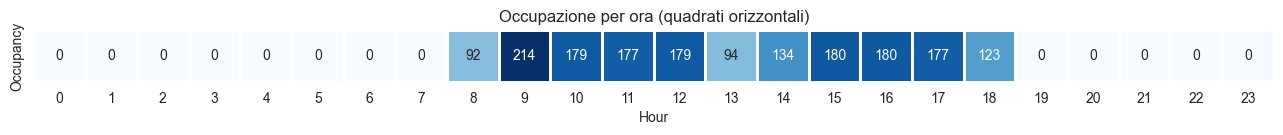

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

X["Hour"] = pd.to_datetime(X["date"]).dt.round("h").dt.hour


occupancy_by_hour = X[["Hour", "Occupancy"]]

grouped_by_hour = occupancy_by_hour.groupby("Hour")

grouped_by_hour.sum()

hourly_occupation_samples = grouped_by_hour.sum()


plt.figure(figsize=(16, 2))
sns.heatmap(
    hourly_occupation_samples.T,
    annot=True,
    cmap="Blues",
    square=True,
    cbar=False,
    linewidths=1,
    linecolor="white",
    fmt="d"
)

plt.title("Occupazione per ora (quadrati orizzontali)")
plt.xlabel("Hour")
plt.show()


Proviamo a rappresentare, usando dei box plot, la distribuzione delle feature rispetto al fatto che il campione sia contrassegnato come occupato o meno

['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']


Text(0.5, 0.98, "Distribuzioni delle feature in funzione dell'occupazione")

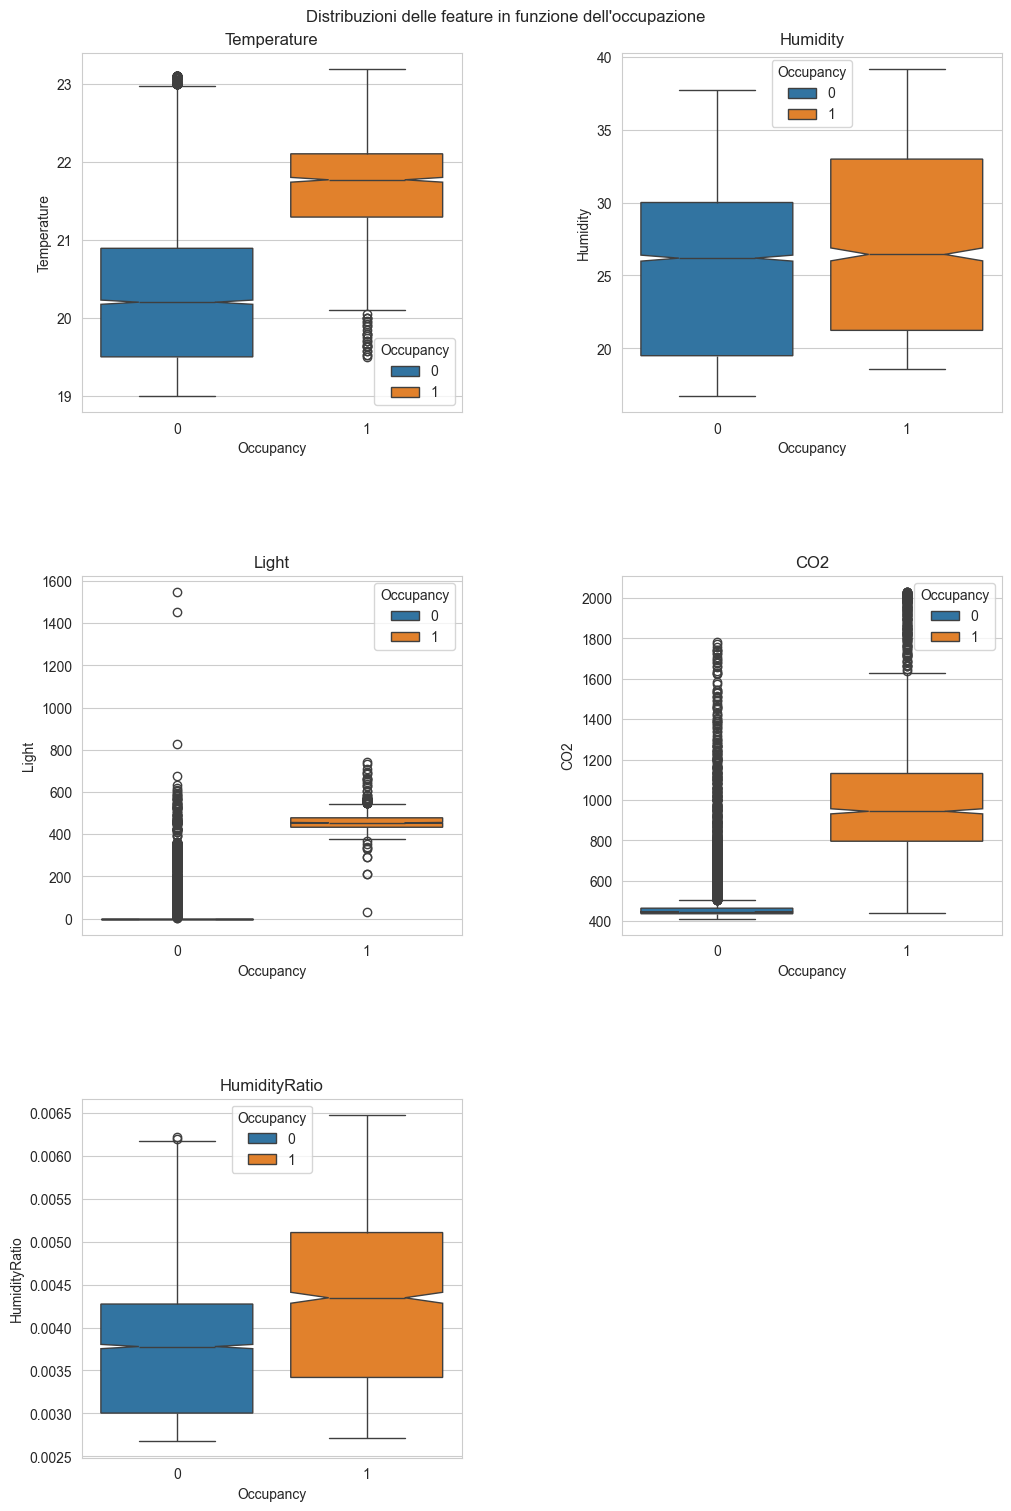

In [41]:
occupancy_by_light = X[["Light", "Occupancy"]]

# grouped_by_occupancy = occupancy_by_light.groupby("Occupancy")
#
# sns.catplot(
#     data=occupancy_by_light,
#     x="Occupancy",
#     y="Light",
#     kind="box",
#     hue="Occupancy",
#     palette="bright"
# )

features = X.columns.tolist()

features.remove('Occupancy')
features.remove('date')
features.remove('weekday')

print(features)


fig, axes = plt.subplots(3, 2, constrained_layout=True, figsize=(10, 15))
fig.set_constrained_layout_pads(hspace=0.2, wspace=0.2)
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    sns.boxplot(
        data=X,
        x="Occupancy",
        y=feat,
        hue="Occupancy",
        palette="tab10",
        notch=True,
        ax=ax,
    )
    ax.set_title(feat)

for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Distribuzioni delle feature in funzione dell\'occupazione')

